Tutorial 1: Predicting the Molecular Type of Neurons
====================================================
To demonstrate some of the main functionalities of CAJAL,
here we perform some basic analysis on a set of neuron
morphological reconstructions obtained from the
[Allen Brain Atlas](https://celltypes.brain-map.org/). To facilitate
the analysis, we provide a compressed \*.tar.gz file containing the \*.SWC
files of 509 neurons used in this example, which can be downloaded directly from this
[link](https://www.dropbox.com/s/aq0ovetjtqihf4f/allen_brain_atlas_509_SWCs_mouse_full_or_dendrite_only.tar.gz?dl=0>). In this tutorial we assume that the SWC files are located in the folder `/home/jovyan/swc`. More information about this dataset can be found at:

\- Gouwens, N. W. et al. [Classification of electrophysiological and morphological neuron types in the mouse visual cortex.](https://www.nature.com/articles/s41593-019-0417-0) Nat Neurosci 22, 1182-1195 (2019).

For this analysis, we focus on the morphology of the dendrites and exclude the
axons of the neurons. To achieve this, we set `structure_ids = [1,3,4]`,
which tells CAJAL to only sample points from the soma and the basal and apical
dendrites. We sample 100 points from each neuron and compute the Euclidean distance
between each pair of points in that neuron using the following code:

In [62]:
import cajal.sample_swc
import cajal.swc
from os.path import join

bd = "/home/jovyan/" # Base directory

cajal.sample_swc.compute_icdm_all_euclidean(
    infolder=join(bd, 'swc'),
    out_csv=join(bd, 'swc_bdad_100pts_euclidean_icdm.csv'),
    preprocess=cajal.swc.preprocessor_eu(
        structure_ids=[1,3,4],
        soma_component_only=False),
    n_sample=100,
    num_processes=8)  # num_processes can be set to the number of cores on your machine

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 508/509 [02:49<00:00,  3.00it/s]


[]

Once the sampling is completed, we compute the Gromov-Wasserstein distance
between each pair of neurons. To compute the Gromov-Wasserstein distance matrix we use
the code:

In [63]:
import cajal.run_gw

cajal.run_gw.compute_gw_distance_matrix(
    join(bd, 'swc_bdad_100pts_euclidean_icdm.csv'),
    join(bd, 'swc_bdad_100pts_euclidean_GW_dmat.csv'),
    num_processes=8)  

  0%|          | 0/129286 [00:00<?, ?it/s]

(array([[  0.        ,  76.53525355,  48.81215985, ...,  36.25765651,
          39.63267218, 107.27192268],
        [ 76.53525355,   0.        ,  90.55259238, ...,  69.27173625,
          82.74822498,  50.54451328],
        [ 48.81215985,  90.55259238,   0.        , ...,  26.48503494,
          16.99102489, 129.81156708],
        ...,
        [ 36.25765651,  69.27173625,  26.48503494, ...,   0.        ,
          21.15960915, 107.41792624],
        [ 39.63267218,  82.74822498,  16.99102489, ...,  21.15960915,
           0.        , 121.93211717],
        [107.27192268,  50.54451328, 129.81156708, ..., 107.41792624,
         121.93211717,   0.        ]]),
 None)

We can visualize the resulting space of cell morphologies using UMAP:

In [65]:
import plotly.io as pio
pio.renderers.default = 'iframe'

import cajal.utilities
import umap
import plotly.express

# Read GW distance matrix
cells, gw_dist_dict = cajal.utilities.read_gw_dists(join(bd,"swc_bdad_100pts_euclidean_GW_dmat.csv"), header=True)
gw_dist = cajal.utilities.dist_mat_of_dict(gw_dist_dict, cells)

# Compute UMAP representation
reducer = umap.UMAP(metric="precomputed", random_state=1)
embedding = reducer.fit_transform(gw_dist)

# Visualize UMAP
plotly.express.scatter(x=embedding[:,0], 
                       y=embedding[:,1], 
                       template="simple_white", 
                       hover_name=[m + ".swc" for m in cells])

/home/patn/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/home/patn/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Once the user has computed the Gromov-Wasserstein distances between cells it is
possible to cluster the cells using standard clustering techniques. The Louvain
and Leiden clustering algorithms are two commonly used
algorithms to identify communities within large networks; they can be adapted
to finite metric spaces by constructing a `k`-nearest-neighbors graph on top of
the metric space. CAJAL provides access to both of these clustering
algorithms. When combined with a low-dimensional embedding tool such as the
UMAP algorithm, the user can plot the clusters in a 2-dimensional embedding and
visualize them. Here, we use the Leiden algorithm to cluster the neurons based on their morphology:

In [66]:
clusters = cajal.utilities.leiden_clustering(gw_dist, seed=1)
plotly.express.scatter(x=embedding[:,0], 
                       y=embedding[:,1], 
                       template="simple_white", 
                       hover_name=[m + ".swc" for m in cells],
                       color = [str(m) for m in clusters])

As expected, cells belonging to the same cluster have similar morphology. For example,
let us visualize some of the cells in the brown cluster (cluster 8) using the Python package [NAVis](https://navis.readthedocs.io/en/latest/index.html>) (which can be installed using `pip install navis`):

(<Figure size 720x720 with 1 Axes>, <Axes3D: >)

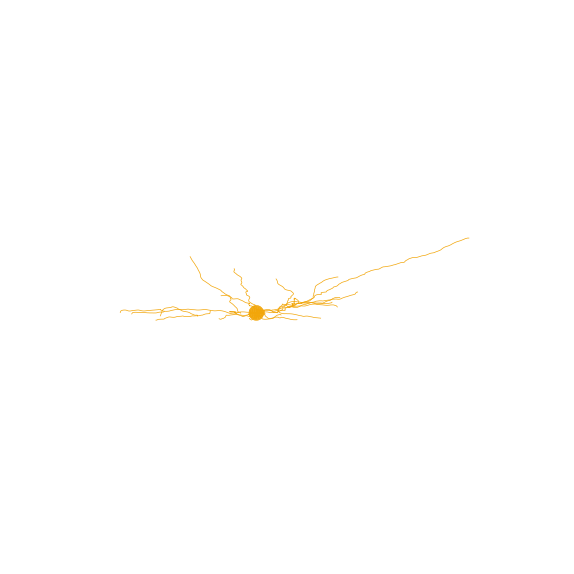

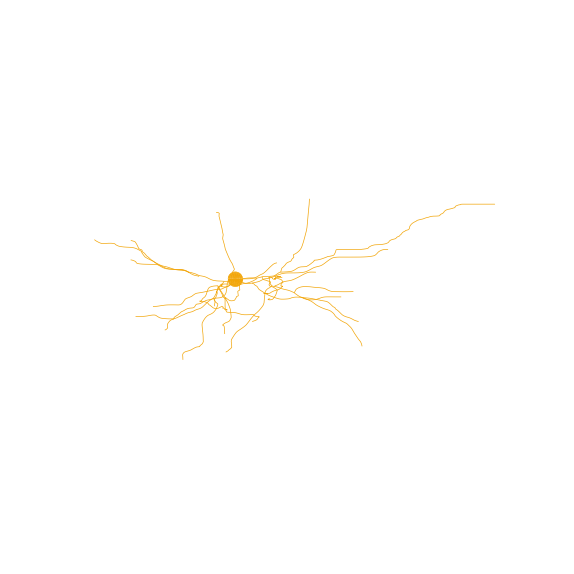

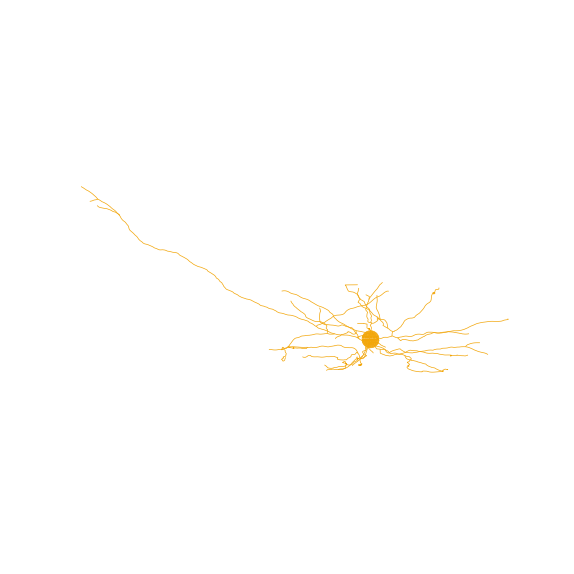

In [77]:
import navis

cells_cluster_8 = [n for m, n in zip(clusters, cells) if m==8]
cluster_8 = [navis.read_swc(join(bd,"swc/" + n + ".swc")) for n in cells_cluster_8]

cluster_8[1].plot2d()
cluster_8[2].plot2d()
cluster_8[3].plot2d()

NAVis offers many other great functionalities, including interactive 3D visualizations of the neurons. More information about those functionalities can be found at the [NAVis documentation](https://navis.readthedocs.io/en/latest/index.html>).

We can also compute the medoid of the cluster, i. e. the most central
neuron of the cluster (and therefore a good representative of the
morphologies present in the cluster), and visualize it:

(<Figure size 720x720 with 1 Axes>, <Axes3D: >)

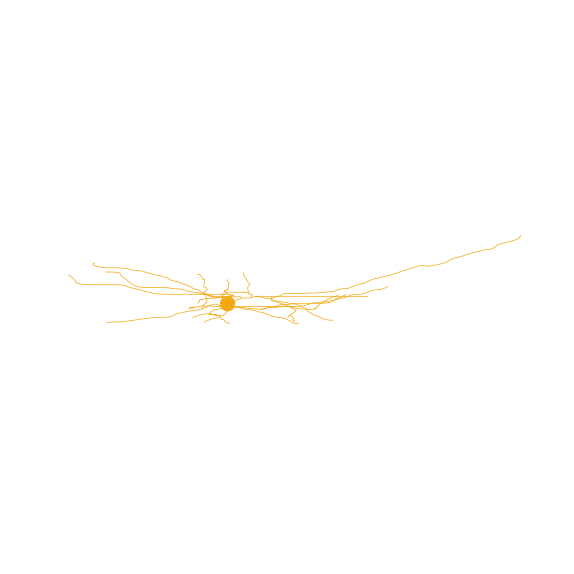

In [78]:
medoid_8 = navis.read_swc(join(bd,'swc/' + cajal.utilities.identify_medoid(cells_cluster_8, gw_dist_dict) + ".swc"))
medoid_8.plot2d()

CAJAL allows the user to visualize the components of each neuron which contribute the most to the overall distortion score. 
Here, we compare the medoid neurons of the 5th cluster and 8th cluster. The red and pink regions of the neurons are obstacles to a clean fit between the neurons; they suggest key regions of the two shapes which represent morphological distinctions between the two cells, and by extension between the two clusters.

In [92]:
from cajal.deformation_vis import navis_heatmap

cells_cluster_5 = [n for m, n in zip(clusters, cells) if m==5]
medoid_5 = navis.read_swc(join(bd,'swc/' + cajal.utilities.identify_medoid(cells_cluster_5, gw_dist_dict) + ".swc"))
(heatmap_5, heatmap_8) = navis_heatmap(
    medoid_5,
    200,
    medoid_8,
    200
)

(<Figure size 720x720 with 1 Axes>, <Axes3D: >)

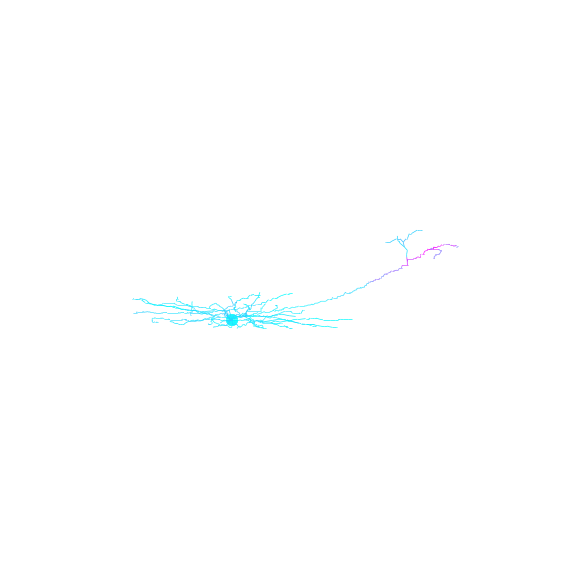

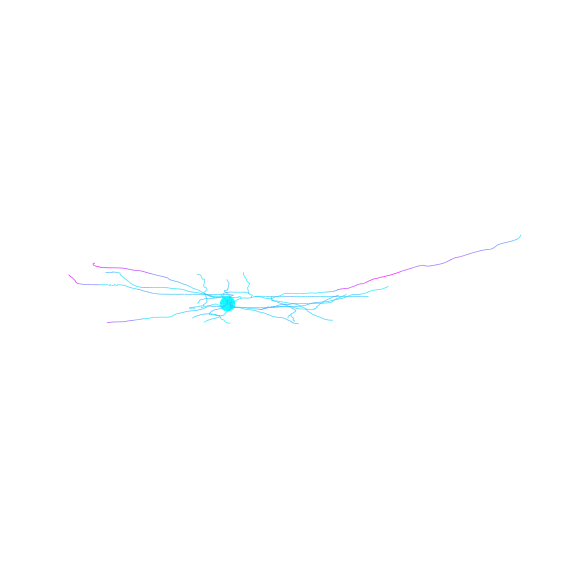

In [93]:
heatmap_5.plot2d(color_by='distortion', palette='cool')
heatmap_8.plot2d(color_by='distortion', palette='cool')

The file ``CAJAL/data/cell_types_specimen_details.csv`` in the GitHub repository of CAJAL
contains metadata for each of the neurons in this example, including the layer, Cre line, etc.
Here we color the above UMAP representation by the cortical layer of each neuron:

In [94]:
import pandas

metadata = pandas.read_csv(join(bd,"CAJAL/data/cell_types_specimen_details.csv"))
metadata.index = [str(m) for m in metadata["specimen__id"]]
metadata = metadata.loc[cells]

plotly.express.scatter(x=embedding[:,0], 
                       y=embedding[:,1], 
                       template="simple_white", 
                       hover_name=[m + ".swc" for m in cells],
                       color = metadata["structure__layer"])

As shown in the visualization, different cortical layers seem to be
associated with specific regions of the cell morphology space. We can quantify
statistically the association using the Laplacian score:

In [95]:
import cajal.laplacian_score
import numpy
import pandas
from scipy.spatial.distance import squareform

# Build indicator matrix
layers = numpy.unique(metadata["structure__layer"])
indicator = (numpy.array(metadata["structure__layer"])[:,None] == layers)*1

# Compute the Laplacian score
laplacian = pandas.DataFrame(cajal.laplacian_score.laplacian_scores(indicator, 
                                       gw_dist, 
                                       numpy.median(squareform(gw_dist)), 
                                       permutations = 5000, 
                                       covariates = None, 
                                       return_random_laplacians = False)[0])
laplacian.index = layers

print(laplacian)

     feature_laplacians  laplacian_p_values  laplacian_q_values
1              0.976439              0.0002             0.00060
2/3            0.968968              0.0002             0.00060
4              0.970067              0.0002             0.00060
5              0.987542              0.0006             0.00090
6a             0.992997              0.0020             0.00200
6b             0.992043              0.0014             0.00168


We observe that indeed all cortical layers are significantly associated with distinct
regions of the cell morphology space with false discovery rates (FDRs) < 0.05.

We could perform a similar analysis with other features. Alternatively, we could
build a classifier to predict the value of each feature based on the position of the cells in
the cell morphology space. For example, each neuron in the dataset is derived
from a specific Cre driver line, which preferentially labels distinct neuronal types.
Neurons from the same Cre driver line therefore tend to have similar morphologies, and
a Laplacian score analysis would show that many Cre driver lines are significantly
associated with distinct regions of the cell morphology space. As a result, it is
possible to predict the Cre driver line of a neuron based on its morphological features.

To accomplish this, we train a nearest-neighbors classifier on the GW distance matrix and
evaluate its accuracy using 7-fold cross-validation:

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

cre_lines = numpy.array(metadata["line_name"])

clf = KNeighborsClassifier(metric="precomputed", n_neighbors=10, weights="distance")
cv = StratifiedKFold(n_splits=7, shuffle=True)
accuracy = cross_val_score(clf, X=gw_dist, y=cre_lines,cv=cv)

numpy.mean(accuracy)

/home/patn/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=7.



0.2790008697542944

Similarly, we can compute the
[Matthews correlation coefficient](https://bmcgenomics.biomedcentral.com/counter/pdf/10.1186/s12864-019-6413-7.pdf) 
of the classification, which appropriately weights the error arising from misclassifying
elements of smaller classes:

In [102]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import matthews_corrcoef

cvp = cross_val_predict(clf, X=gw_dist, y=cre_lines, cv=cv)

print(matthews_corrcoef(cvp, cre_lines))

0.23734504666518427


/home/patn/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=7.

